In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
import time
import psutil
import os

In [3]:
def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

n_samples = 1500
X_swiss_roll, y_swiss_roll = make_swiss_roll(n_samples=n_samples, noise=0.1)

def plot_projection(X_reduced_2d, X_reduced_3d, title_2d, title_3d):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.scatter(X_reduced_2d[:, 0], X_reduced_2d[:, 1], alpha=0.5, s=1)
    ax1.set_title(title_2d)
    ax1.set_xlabel('Componente 1')
    ax1.set_ylabel('Componente 2')
    
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_reduced_3d[:, 0], X_reduced_3d[:, 1], X_reduced_3d[:, 2], alpha=0.5, s=1)
    ax2.set_title(title_3d)
    ax2.set_xlabel('Componente 1')
    ax2.set_ylabel('Componente 2')
    ax2.set_zlabel('Componente 3')

    plt.show()

Erro de reconstrução (PCA): 0.0000
Tempo de execução (PCA): 2.0167 segundos
Memória usada (PCA): 152.69 MB


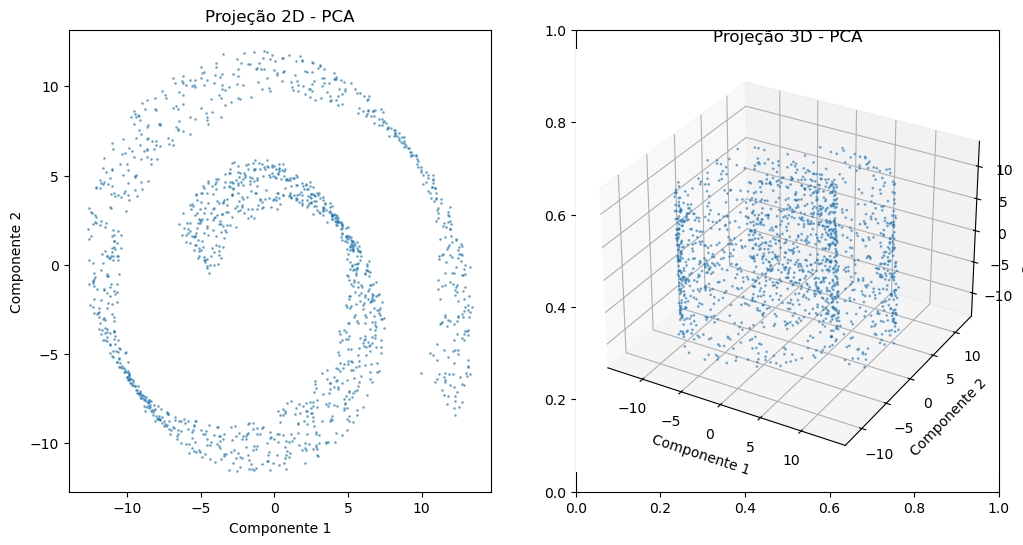

In [4]:
start_pca = time.time()
pca_swiss_roll = PCA()
pca_swiss_roll.fit(X_swiss_roll)
sum_variance = np.cumsum(pca_swiss_roll.explained_variance_ratio_)
d = np.argmax(sum_variance >= 0.78) + 1
pca_swiss_roll = PCA(d)
X_pca_reduced = pca_swiss_roll.fit_transform(X_swiss_roll)
X_reconstructed_pca = pca_swiss_roll.inverse_transform(X_pca_reduced)
reconstruction_error_pca = mean_squared_error(X_swiss_roll, X_reconstructed_pca)
end_pca = time.time()

print(f"Erro de reconstrução (PCA): {reconstruction_error_pca:.4f}")
print(f"Tempo de execução (PCA): {end_pca - start_pca:.4f} segundos")
print(f"Memória usada (PCA): {memory_usage():.2f} MB")
plot_projection(X_pca_reduced[:, :2], X_pca_reduced, 'Projeção 2D - PCA', 'Projeção 3D - PCA')



Erro de reconstrução (IncrementalPCA): 0.0000
Tempo de execução (IncrementalPCA): 0.1243 segundos
Memória usada (IncrementalPCA): 160.82 MB


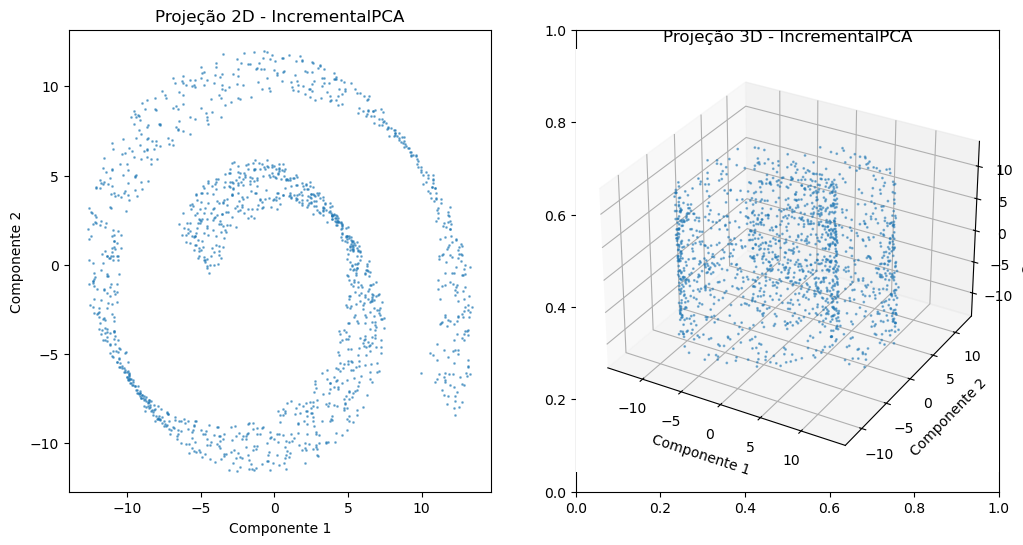

In [5]:
n_batches = 100
start_ipca = time.time()
inc_pca = IncrementalPCA(n_components=d)
for X_batch in np.array_split(X_swiss_roll, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_ipca = inc_pca.transform(X_swiss_roll)
X_reconstructed_ipca = inc_pca.inverse_transform(X_reduced_ipca)
reconstruction_error_ipca = mean_squared_error(X_swiss_roll, X_reconstructed_ipca)
end_ipca = time.time()

print(f"Erro de reconstrução (IncrementalPCA): {reconstruction_error_ipca:.4f}")
print(f"Tempo de execução (IncrementalPCA): {end_ipca - start_ipca:.4f} segundos")
print(f"Memória usada (IncrementalPCA): {memory_usage():.2f} MB")
plot_projection(X_reduced_ipca[:, :2], X_reduced_ipca, 'Projeção 2D - IncrementalPCA', 'Projeção 3D - IncrementalPCA')


Erro de reconstrução (johnson_lindenstrauss Projection): 0.0000
Tempo de execução (johnson_lindenstrauss Projection): 0.0903 segundos
Memória usada (johnson_lindenstrauss Projection): 235.54 MB


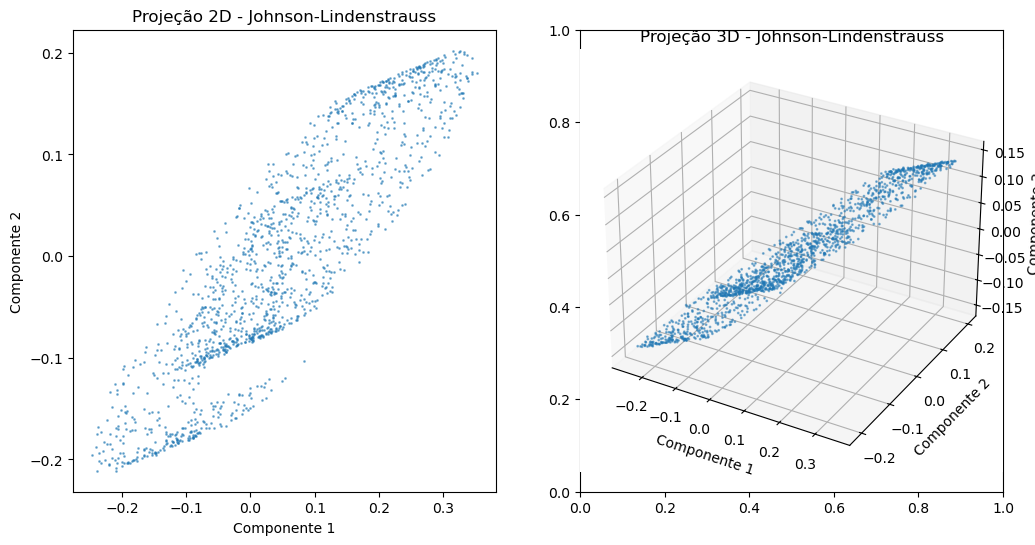

In [6]:
start_john = time.time()
m, ε = n_samples, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
P = np.random.randn(d, X_swiss_roll.shape[1]) / np.sqrt(d)

X_reduced = X_swiss_roll @ P.T

X_reduced_2d = X_reduced[:, :2]
X_reduced_3d = X_reduced[:, :3]
X_reconstructed = X_reduced @ np.linalg.pinv(P).T
reconstruction_error_john = mean_squared_error(X_swiss_roll, X_reconstructed)

end_john = time.time()
time_john = end_john - start_john

print(f"Erro de reconstrução (johnson_lindenstrauss Projection): {reconstruction_error_john:.4f}")
print(f"Tempo de execução (johnson_lindenstrauss Projection): {time_john:.4f} segundos")
print(f"Memória usada (johnson_lindenstrauss Projection): {memory_usage():.2f} MB")
plot_projection(X_reduced_2d, X_reduced_3d, "Projeção 2D - Johnson-Lindenstrauss", "Projeção 3D - Johnson-Lindenstrauss")


Erro de reconstrução (Gaussian Random Projection): 0.0000
Tempo de execução (Gaussian Random Projection): 0.0310 segundos
Memória usada (Gaussian Random Projection): 239.52 MB


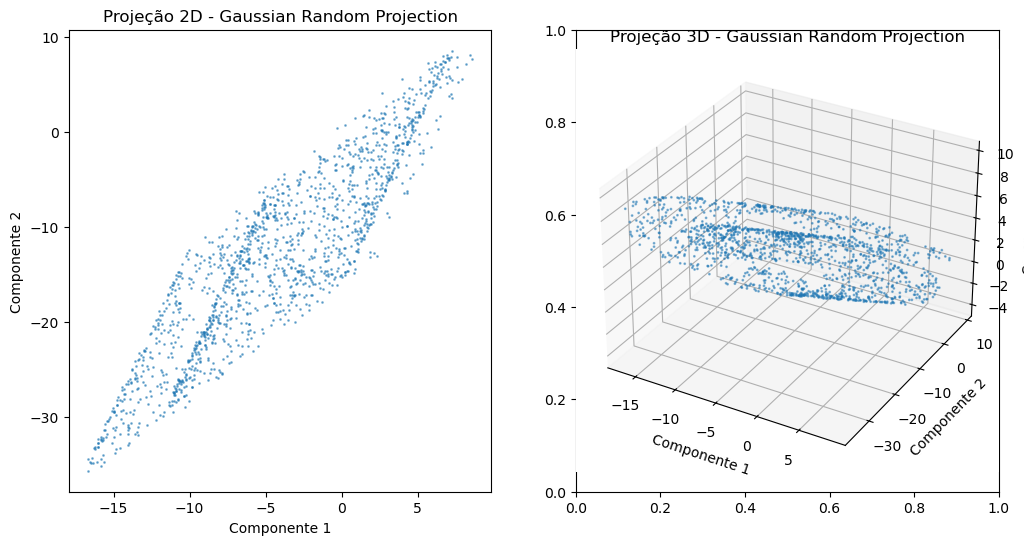

In [7]:
epsilon = 0.1
d_max = X_swiss_roll.shape[1]  
start_grp = time.time()

gaussian_rnd_proj = GaussianRandomProjection(n_components=d_max, eps=epsilon, random_state=60)
X_reduced_grp = gaussian_rnd_proj.fit_transform(X_swiss_roll)
X_reconstructed_grp = X_reduced_grp @ np.linalg.pinv(gaussian_rnd_proj.components_).T
reconstruction_error_grp = mean_squared_error(X_swiss_roll, X_reconstructed_grp)
end_grp = time.time()

print(f"Erro de reconstrução (Gaussian Random Projection): {reconstruction_error_grp:.4f}")
print(f"Tempo de execução (Gaussian Random Projection): {end_grp - start_grp:.4f} segundos")
print(f"Memória usada (Gaussian Random Projection): {memory_usage():.2f} MB")
plot_projection(X_reduced_grp[:, :2], X_reduced_grp, 'Projeção 2D - Gaussian Random Projection', 'Projeção 3D - Gaussian Random Projection')


Erro de reconstrução (Sparse Random Projection): 64.9076
Tempo de execução (Sparse Random Projection): 0.1741 segundos
Memória usada (Sparse Random Projection): 243.83 MB


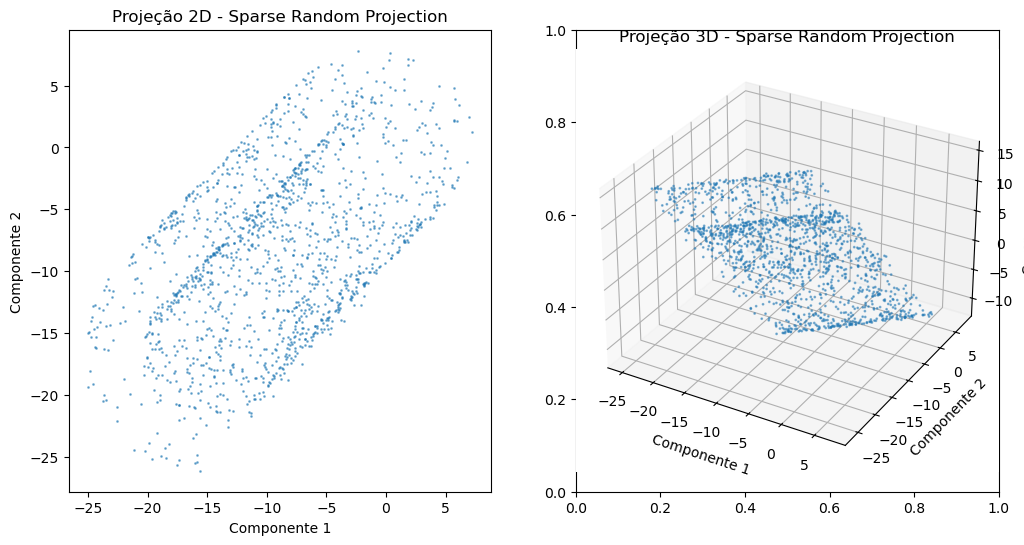

In [8]:
n_components = 3
epsilon = 0.99

start_srp = time.time()

sparse_rnd_proj = SparseRandomProjection(n_components=n_components, eps=epsilon, random_state=60)

X_reduced_srp = sparse_rnd_proj.fit_transform(X_swiss_roll)

X_reconstructed_srp = X_reduced_srp @ sparse_rnd_proj.components_

reconstruction_error_srp = mean_squared_error(X_swiss_roll, X_reconstructed_srp)

end_srp = time.time()

print(f"Erro de reconstrução (Sparse Random Projection): {reconstruction_error_srp:.4f}")
print(f"Tempo de execução (Sparse Random Projection): {end_srp - start_srp:.4f} segundos")
print(f"Memória usada (Sparse Random Projection): {memory_usage():.2f} MB")

plot_projection(X_reduced_srp[:, :2], X_reduced_srp, 'Projeção 2D - Sparse Random Projection', 'Projeção 3D - Sparse Random Projection')

Tempo de execução (LLE): 0.8545 segundos
Memória usada (LLE): 250.66 MB


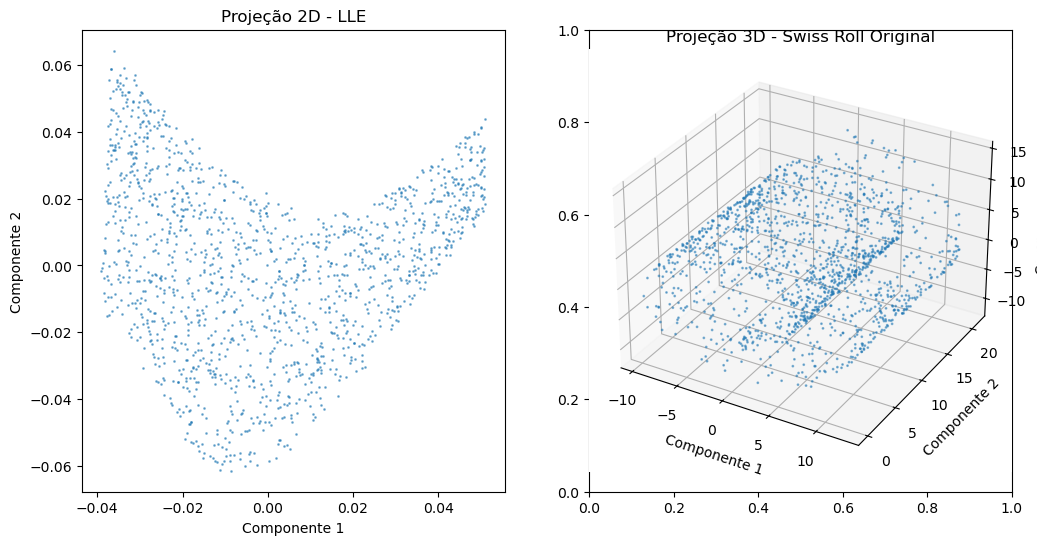

In [9]:
start_lle = time.time()
lle = LocallyLinearEmbedding(n_neighbors=12, n_components=2, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss_roll)
end_lle = time.time()

memory_used_lle = memory_usage()

print(f"Tempo de execução (LLE): {end_lle - start_lle:.4f} segundos")
print(f"Memória usada (LLE): {memory_used_lle:.2f} MB")


plot_projection(X_reduced_lle, X_swiss_roll, 'Projeção 2D - LLE', 'Projeção 3D - Swiss Roll Original')

In [10]:
print(f"Erro de reconstrução (PCA): {reconstruction_error_pca:.4f}")
print(f"Tempo de execução (PCA): {end_pca - start_pca:.4f} segundos")
print(f"Memória usada (PCA): {memory_usage():.2f} MB")

print(f"Erro de reconstrução (IncrementalPCA): {reconstruction_error_ipca:.4f}")
print(f"Tempo de execução (IncrementalPCA): {end_ipca - start_ipca:.4f} segundos")
print(f"Memória usada (IncrementalPCA): {memory_usage():.2f} MB")

print(f"Erro de reconstrução (johnson_lindenstrauss Projection): {reconstruction_error_john:.4f}")
print(f"Tempo de execução (johnson_lindenstrauss Projection): {time_john:.4f} segundos")
print(f"Memória usada (johnson_lindenstrauss Projection): {memory_usage():.2f} MB")

print(f"Erro de reconstrução (Gaussian Random Projection): {reconstruction_error_grp:.4f}")
print(f"Tempo de execução (Gaussian Random Projection): {end_grp - start_grp:.4f} segundos")
print(f"Memória usada (Gaussian Random Projection): {memory_usage():.2f} MB")

print(f"Erro de reconstrução (Sparse Random Projection): {reconstruction_error_srp:.4f}")
print(f"Tempo de execução (Sparse Random Projection): {end_srp - start_srp:.4f} segundos")
print(f"Memória usada (Sparse Random Projection): {memory_usage():.2f} MB")

print(f"Tempo de execução (LLE): {end_lle - start_lle:.4f} segundos")
print(f"Memória usada (LLE): {memory_used_lle:.2f} MB")



Erro de reconstrução (PCA): 0.0000
Tempo de execução (PCA): 2.0167 segundos
Memória usada (PCA): 254.12 MB
Erro de reconstrução (IncrementalPCA): 0.0000
Tempo de execução (IncrementalPCA): 0.1243 segundos
Memória usada (IncrementalPCA): 254.12 MB
Erro de reconstrução (johnson_lindenstrauss Projection): 0.0000
Tempo de execução (johnson_lindenstrauss Projection): 0.0903 segundos
Memória usada (johnson_lindenstrauss Projection): 254.12 MB
Erro de reconstrução (Gaussian Random Projection): 0.0000
Tempo de execução (Gaussian Random Projection): 0.0310 segundos
Memória usada (Gaussian Random Projection): 254.12 MB
Erro de reconstrução (Sparse Random Projection): 64.9076
Tempo de execução (Sparse Random Projection): 0.1741 segundos
Memória usada (Sparse Random Projection): 254.12 MB
Tempo de execução (LLE): 0.8545 segundos
Memória usada (LLE): 250.66 MB
